# CS5100 Group Project

### Import libraries

In [1]:
import tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,15
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from math import sqrt

## NFLX Dataset

### Read the dataset

In [2]:
#Read the dataset for NFLX
df=pd.read_csv("NFLX.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-11-16,309.940002,310.489990,303.609985,306.019989,306.019989,8038600
1,2022-11-15,309.200012,312.709991,302.549988,310.200012,310.200012,14626900
2,2022-11-14,290.000000,311.000000,288.190002,299.269989,299.269989,17978200
3,2022-11-11,274.470001,290.660004,271.559998,290.130005,290.130005,9567300
4,2022-11-10,265.989990,275.359985,260.089996,274.970001,274.970001,9667300


### Analyze the closing prices from dataframe

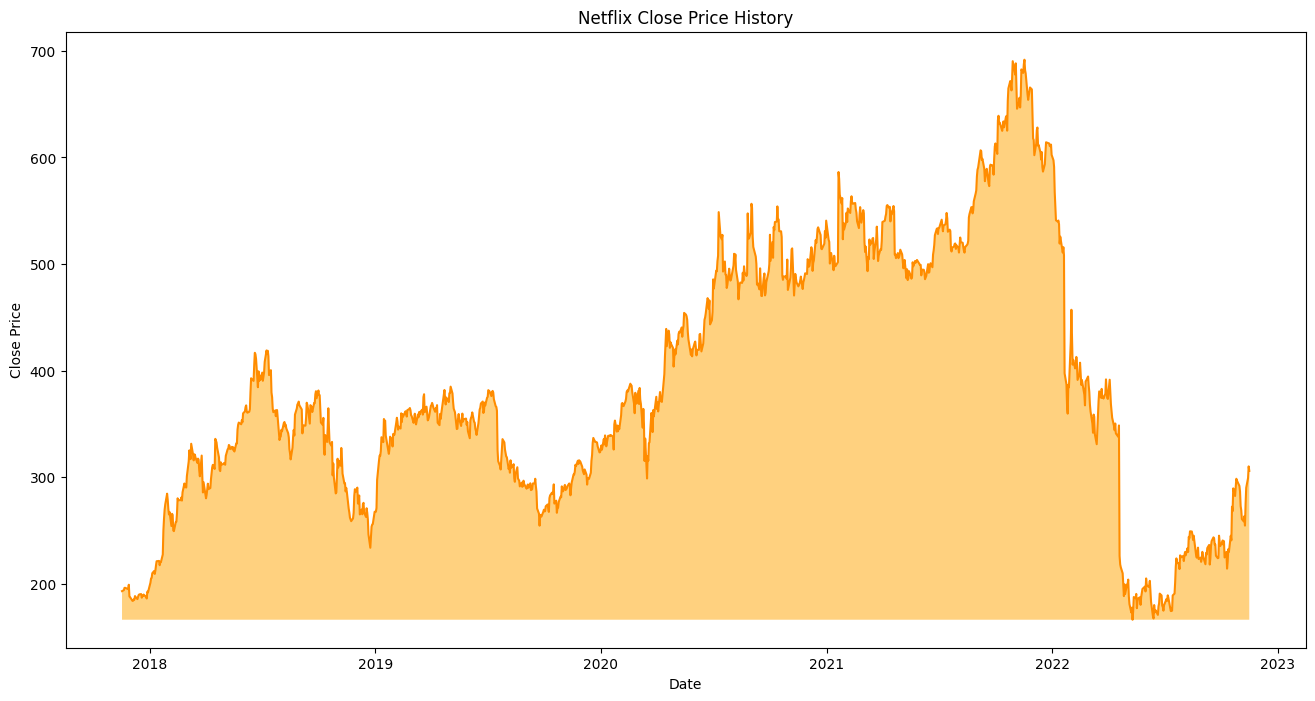

In [3]:
#Analyze the Netflix closing prices from datafrram
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
Closemin = df.Close.min()
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='NFLX Close Price History', color='darkorange')
plt.xlabel('Date')
plt.ylabel('Close Price')

# displaying the title
plt.title("Netflix Close Price History")
plt.fill_between(df.index, Closemin, df.Close, facecolor='orange', alpha = 0.5)

### Build and train the LSTM model for Netflix

In [4]:
#Sort the dataset on date time and filter “Date” and “Close” columns
from keras.models import Sequential
from keras.layers import Dense

data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

#Normalize the new filtered dataset:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset.index=new_dataset.Date

new_dataset.drop("Date",axis=1,inplace=True)


final_dataset=new_dataset.values

train_data=final_dataset[0:1007,:]
valid_data=final_dataset[1007:,:]

scaled_data=scaler.fit_transform(final_dataset)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):

    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

print(x_train_data.shape, y_train_data.shape)

#Build and train the LSTM model:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

(947, 60, 1) (947,)
Metal device set to: Apple M1 Pro


2022-12-15 09:55:06.858097: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-15 09:55:06.858211: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-15 09:55:07.282019: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-15 09:55:08.518937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:55:08.662449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:55:08.787984: I tensorflow/core/grappler/o

947/947 - 29s - loss: 0.0036 - 29s/epoch - 31ms/step


2022-12-15 09:55:36.867360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:55:36.925506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:55:37.044159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 34ms/step


/var/folders/p9/5_9zfv8x779996pp8x3dr8hr0000gn/T/ipykernel_15474/4035361078.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


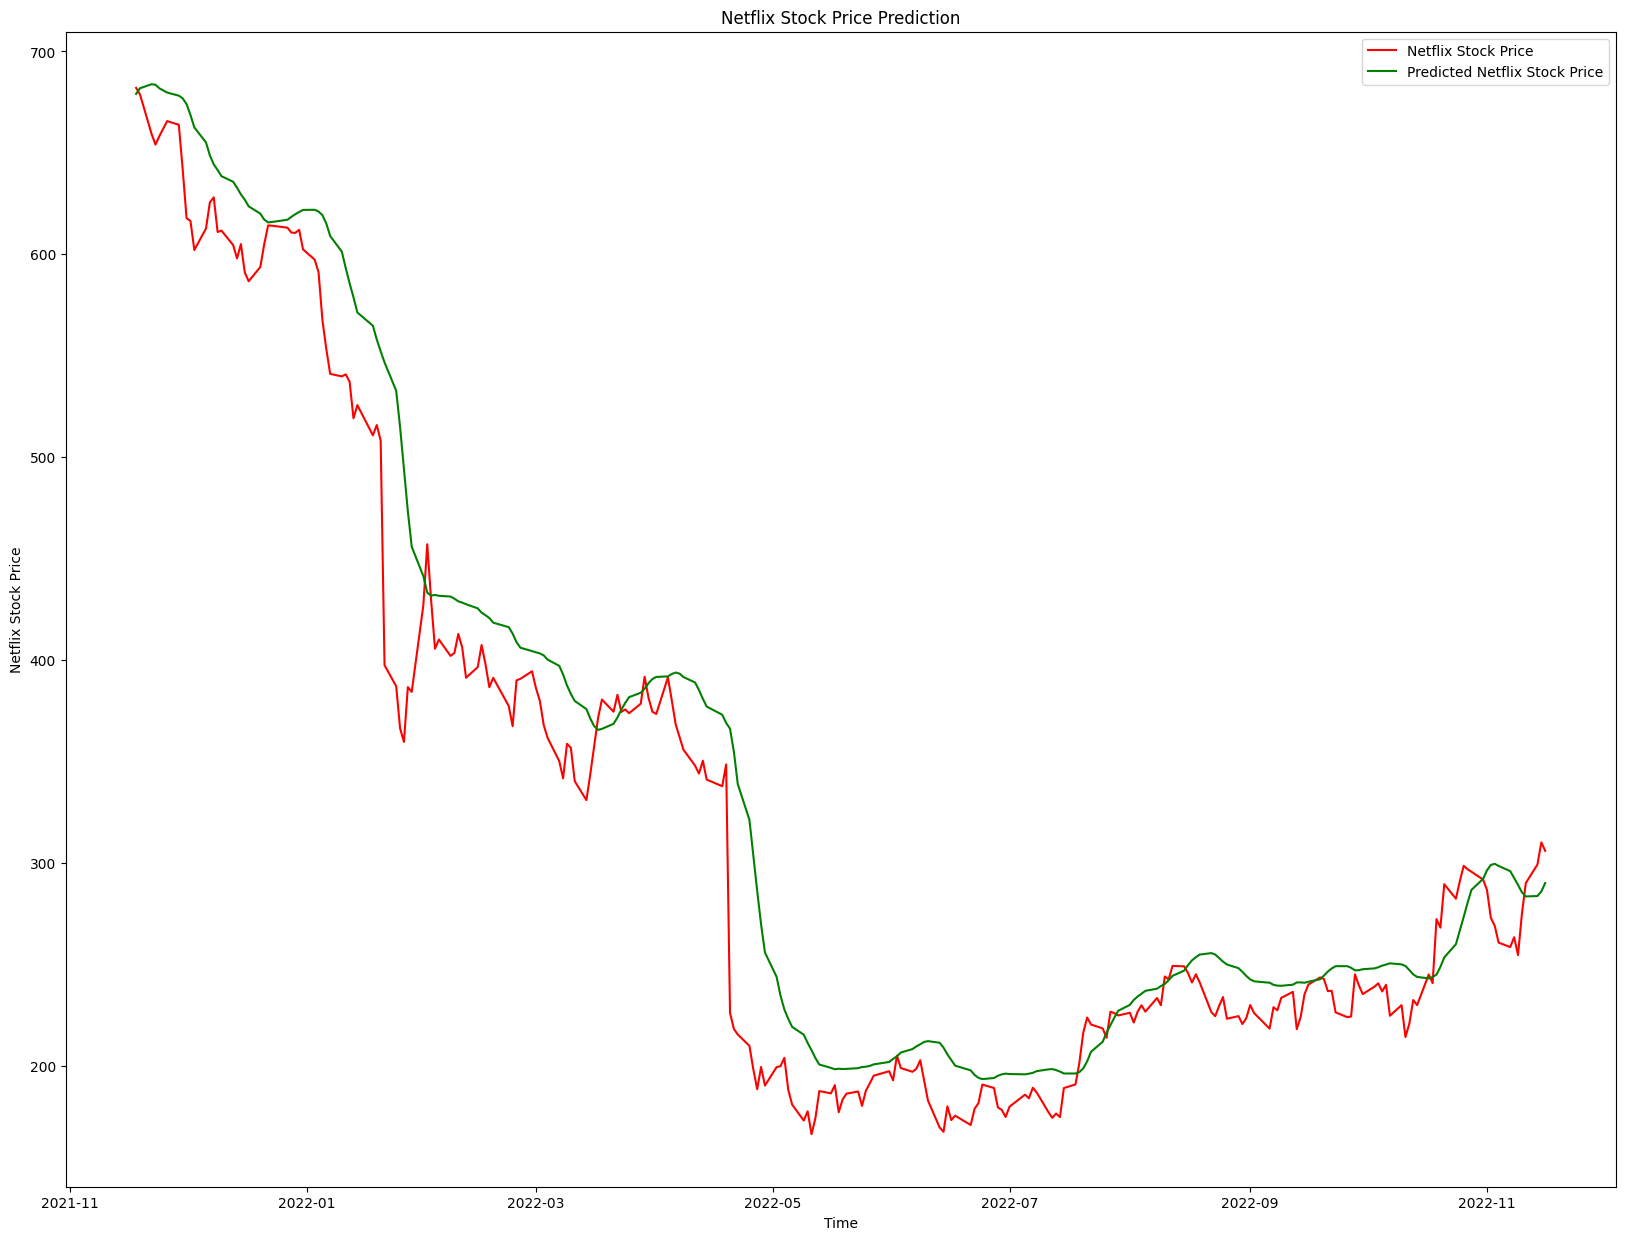

In [5]:
# Take a sample of a dataset to make stock price predictions using the LSTM model
X_test = []
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

#Save the LSTM model
lstm_model.save("saved_model_NFLX.h5")

#Visualize the predicted stock costs with actual stock costs
train_data=new_dataset[:1007]
valid_data=new_dataset[1007:]

valid_data['Predictions']=predicted_closing_price
plt.plot(valid_data['Close'], color = 'red', label = 'Netflix Stock Price')
plt.plot(valid_data['Predictions'], color = 'green', label = 'Predicted Netflix Stock Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Netflix Stock Price')

# displaying the title
plt.title("Netflix Stock Price Prediction")
plt.show()

## Apple Dataset

In [6]:
#Read the dataset for AAPL
df1=pd.read_csv("AAPL.csv")
df1.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,2022-11-17,146.429993,151.479996,146.149994,150.720001,150.720001,80278500,AAPL
1,2022-11-16,149.130005,149.869995,147.289993,148.789993,148.789993,64218300,AAPL
2,2022-11-15,152.220001,153.589996,148.559998,150.039993,150.039993,89868300,AAPL
3,2022-11-14,148.970001,150.279999,147.429993,148.279999,148.279999,73374100,AAPL
4,2022-11-11,145.820007,150.009995,144.369995,149.699997,149.699997,93903800,AAPL


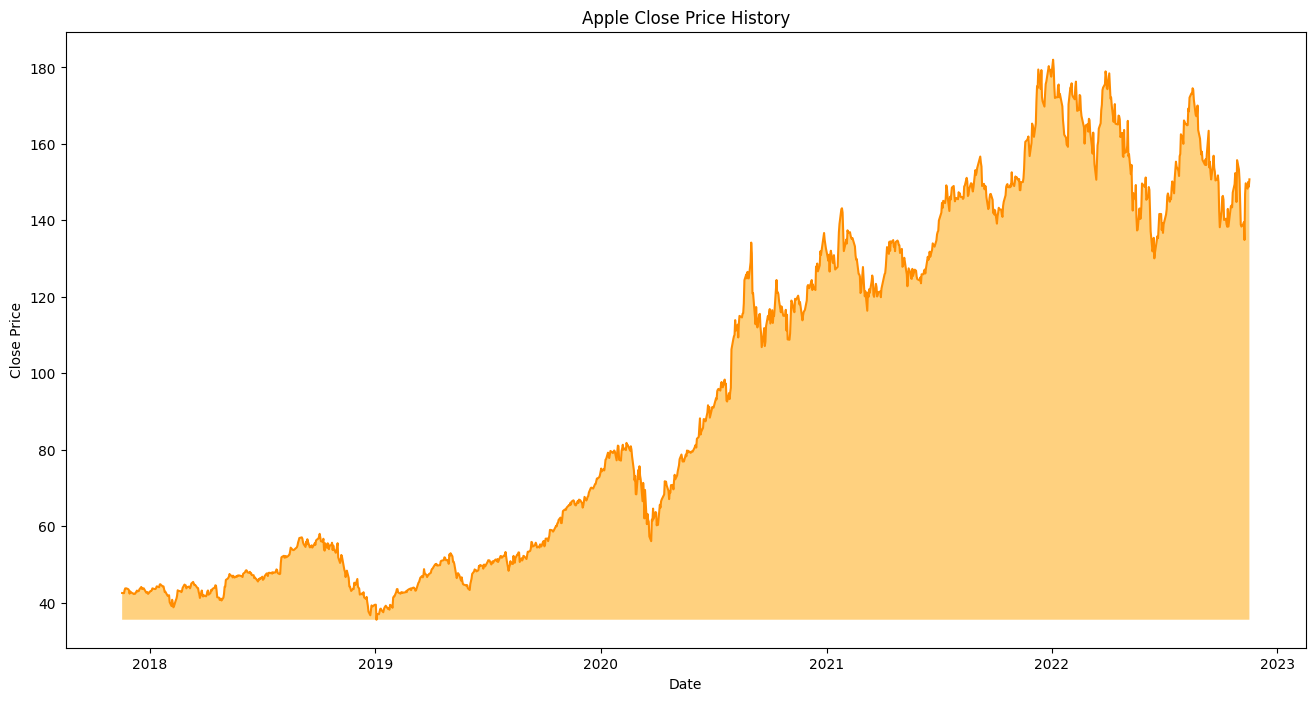

In [7]:
#Analyze the Apple closing prices from dataframe
df1["Date"]=pd.to_datetime(df1.Date,format="%Y-%m-%d")
df1.index=df1['Date']
Closemin = df1.Close.min()
plt.figure(figsize=(16,8))
plt.plot(df1["Close"],label='Apple Close Price History', color='darkorange')
plt.xlabel('Date')
plt.ylabel('Close Price')

# displaying the title
plt.title("Apple Close Price History")
plt.fill_between(df1.index, Closemin, df1.Close, facecolor='orange', alpha = 0.5)

### Build and train the LSTM model for Apple

In [8]:
#Sort the dataset on date time and filter “Date” and “Close” columns
data1=df1.sort_index(ascending=True,axis=0)
new_dataset1=pd.DataFrame(index=range(0,len(df1)),columns=['Date','Close'])
for i in range(0,len(data1)):
    new_dataset1["Date"][i]=data1['Date'][i]
    new_dataset1["Close"][i]=data1["Close"][i]

#Normalize the new filtered dataset:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset1.index=new_dataset1.Date
new_dataset1.drop("Date",axis=1,inplace=True)
final_dataset1=new_dataset1.values

train_data1=final_dataset1[0:1007,:]
valid_data1=final_dataset1[1007:,:]

scaled_data1=scaler.fit_transform(final_dataset1)
x_train_data1,y_train_data1=[],[]
for i in range(60,len(train_data1)):
    x_train_data1.append(scaled_data1[i-60:i,0])
    y_train_data1.append(scaled_data1[i,0])

x_train_data1,y_train_data1=np.array(x_train_data1),np.array(y_train_data1)
x_train_data1=np.reshape(x_train_data1,(x_train_data1.shape[0],x_train_data1.shape[1],1))

#Build and train the LSTM model:
lstm_model1=Sequential()
lstm_model1.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data1.shape[1],1)))
lstm_model1.add(LSTM(units=50))
lstm_model1.add(Dense(1))
inputs_data1=new_dataset1[len(new_dataset1)-len(valid_data1)-60:].values
inputs_data1=inputs_data1.reshape(-1,1)
inputs_data1=scaler.transform(inputs_data1)
lstm_model1.compile(loss='mean_squared_error',optimizer='adam')
lstm_model1.fit(x_train_data1,y_train_data1,epochs=1,batch_size=1,verbose=2)

2022-12-15 09:55:39.658128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:55:39.950313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:55:40.050739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:55:40.203424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:55:40.397178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


947/947 - 31s - loss: 0.0023 - 31s/epoch - 33ms/step


2022-12-15 09:56:09.948924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:56:10.006940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:56:10.098441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 35ms/step


/var/folders/p9/5_9zfv8x779996pp8x3dr8hr0000gn/T/ipykernel_15474/1767354640.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data1['Predictions']=predicted_closing_price1


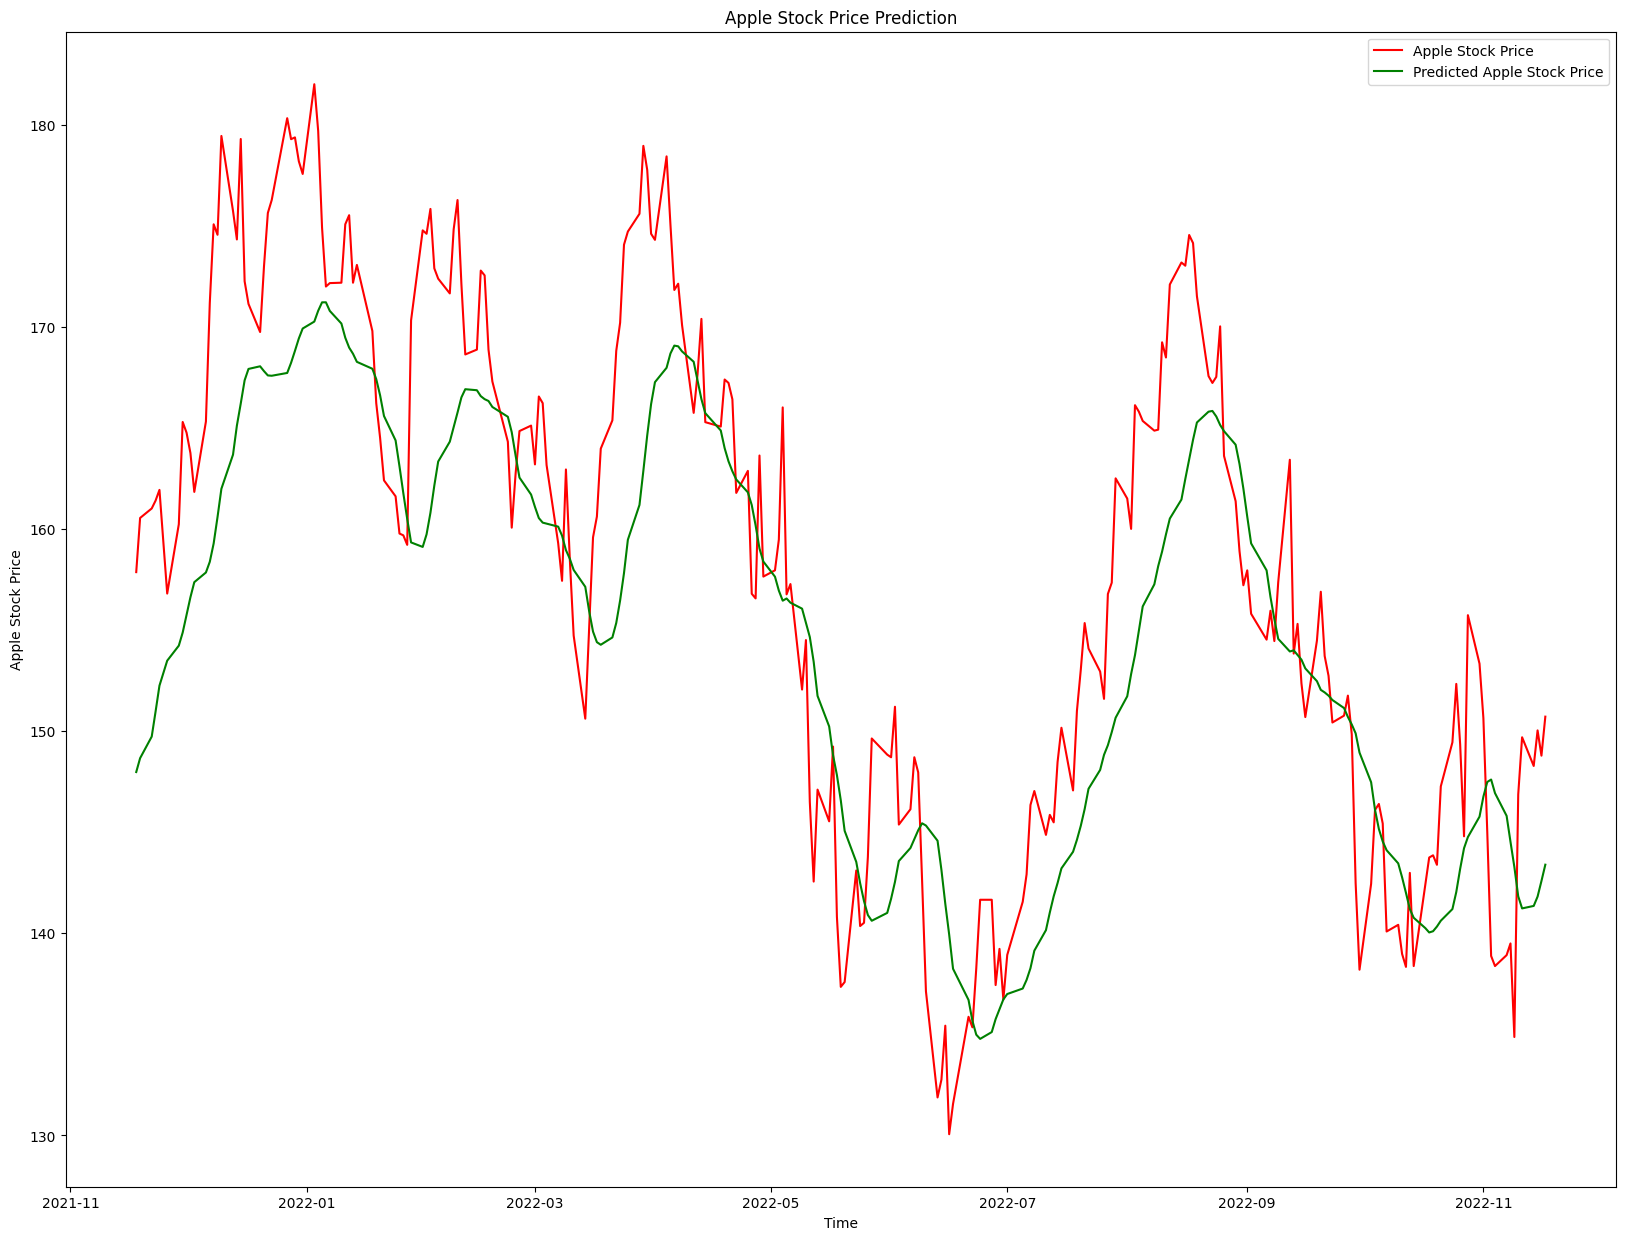

In [9]:
# Take a sample of a dataset to make stock price predictions using the LSTM model
X_test1=[]
for i in range(60,inputs_data1.shape[0]):
    X_test1.append(inputs_data1[i-60:i,0])
X_test1=np.array(X_test1)
X_test1=np.reshape(X_test1,(X_test1.shape[0],X_test1.shape[1],1))
predicted_closing_price1=lstm_model1.predict(X_test1)
predicted_closing_price1=scaler.inverse_transform(predicted_closing_price1)
#Save the LSTM model
lstm_model1.save("saved_model_AAPL.h5")

#Visualize the predicted stock costs with actual stock costs
train_data1=new_dataset1[:1007]
valid_data1=new_dataset1[1007:]
valid_data1['Predictions']=predicted_closing_price1
#plt.plot(train_data1["Close"])
#plt.plot(valid_data1[['Close',"Predictions"]])
plt.plot(valid_data1['Close'], color = 'red', label = 'Apple Stock Price')
plt.plot(valid_data1['Predictions'], color = 'green', label = 'Predicted Apple Stock Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')

# displaying the title
plt.title("Apple Stock Price Prediction")
plt.show()


## Meta Dataset

In [10]:
#Read the dataset for META
df2=pd.read_csv("META.csv")
df2.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,2022-11-17,110.410004,112.330002,109.800003,111.449997,111.449997,35017300,META
1,2022-11-16,114.500000,116.080002,112.660004,113.230003,113.230003,33287800,META
2,2022-11-15,116.070000,118.739998,114.410004,117.080002,117.080002,50670500,META
3,2022-11-14,110.989998,116.269997,110.800003,114.220001,114.220001,53395000,META
4,2022-11-11,109.230003,114.900002,108.809998,113.019997,113.019997,59836400,META


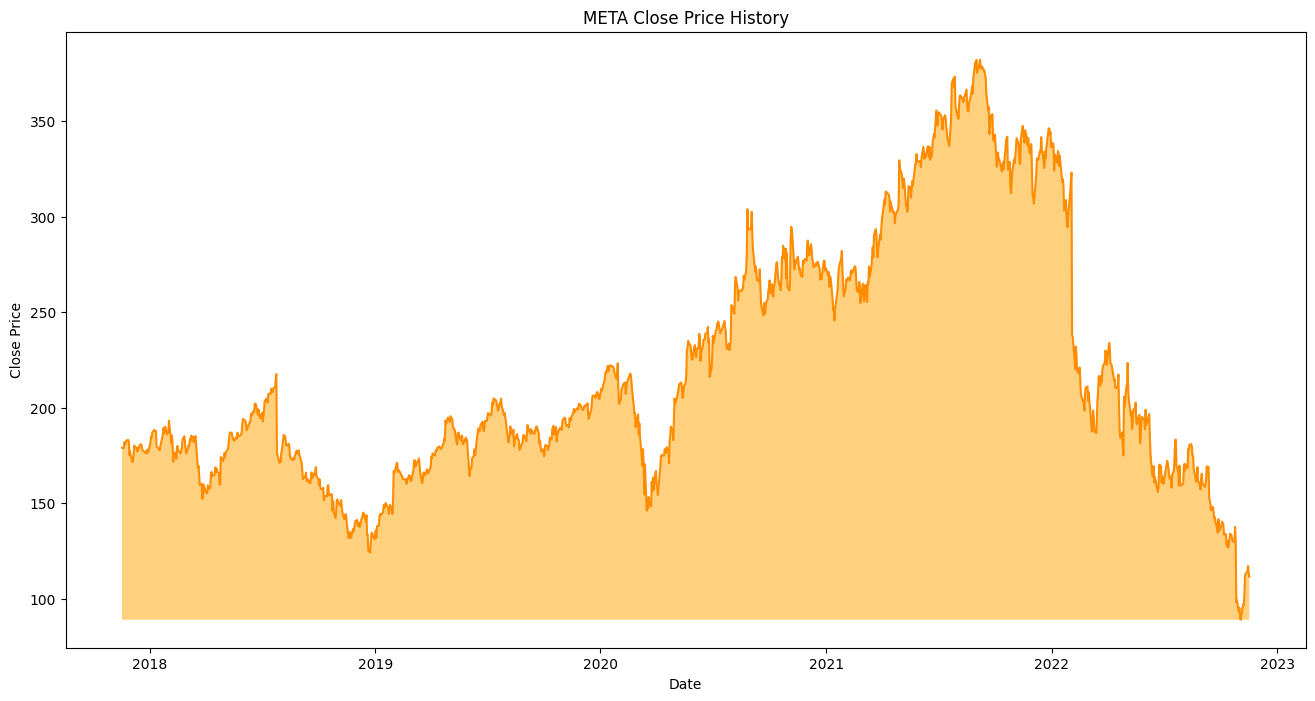

In [11]:
#Analyze the META closing prices from dataframe
df2["Date"]=pd.to_datetime(df2.Date,format="%Y-%m-%d")
df2.index=df2['Date']
Closemin = df2.Close.min()
plt.figure(figsize=(16,8))
plt.plot(df2["Close"],label='META Close Price History', color='darkorange')
plt.xlabel('Date')
plt.ylabel('Close Price')

# displaying the title
plt.title("META Close Price History")
plt.fill_between(df2.index, Closemin, df2.Close, facecolor='orange', alpha = 0.5)

### Build and train the LSTM model for META

2022-12-15 09:56:12.721203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:56:12.856340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:56:12.984014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:56:13.100735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:56:13.290652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


947/947 - 29s - loss: 0.0042 - 29s/epoch - 31ms/step


2022-12-15 09:56:41.026724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:56:41.084434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:56:41.176294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 35ms/step


/var/folders/p9/5_9zfv8x779996pp8x3dr8hr0000gn/T/ipykernel_15474/3457419048.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data2['Predictions']=predicted_closing_price2


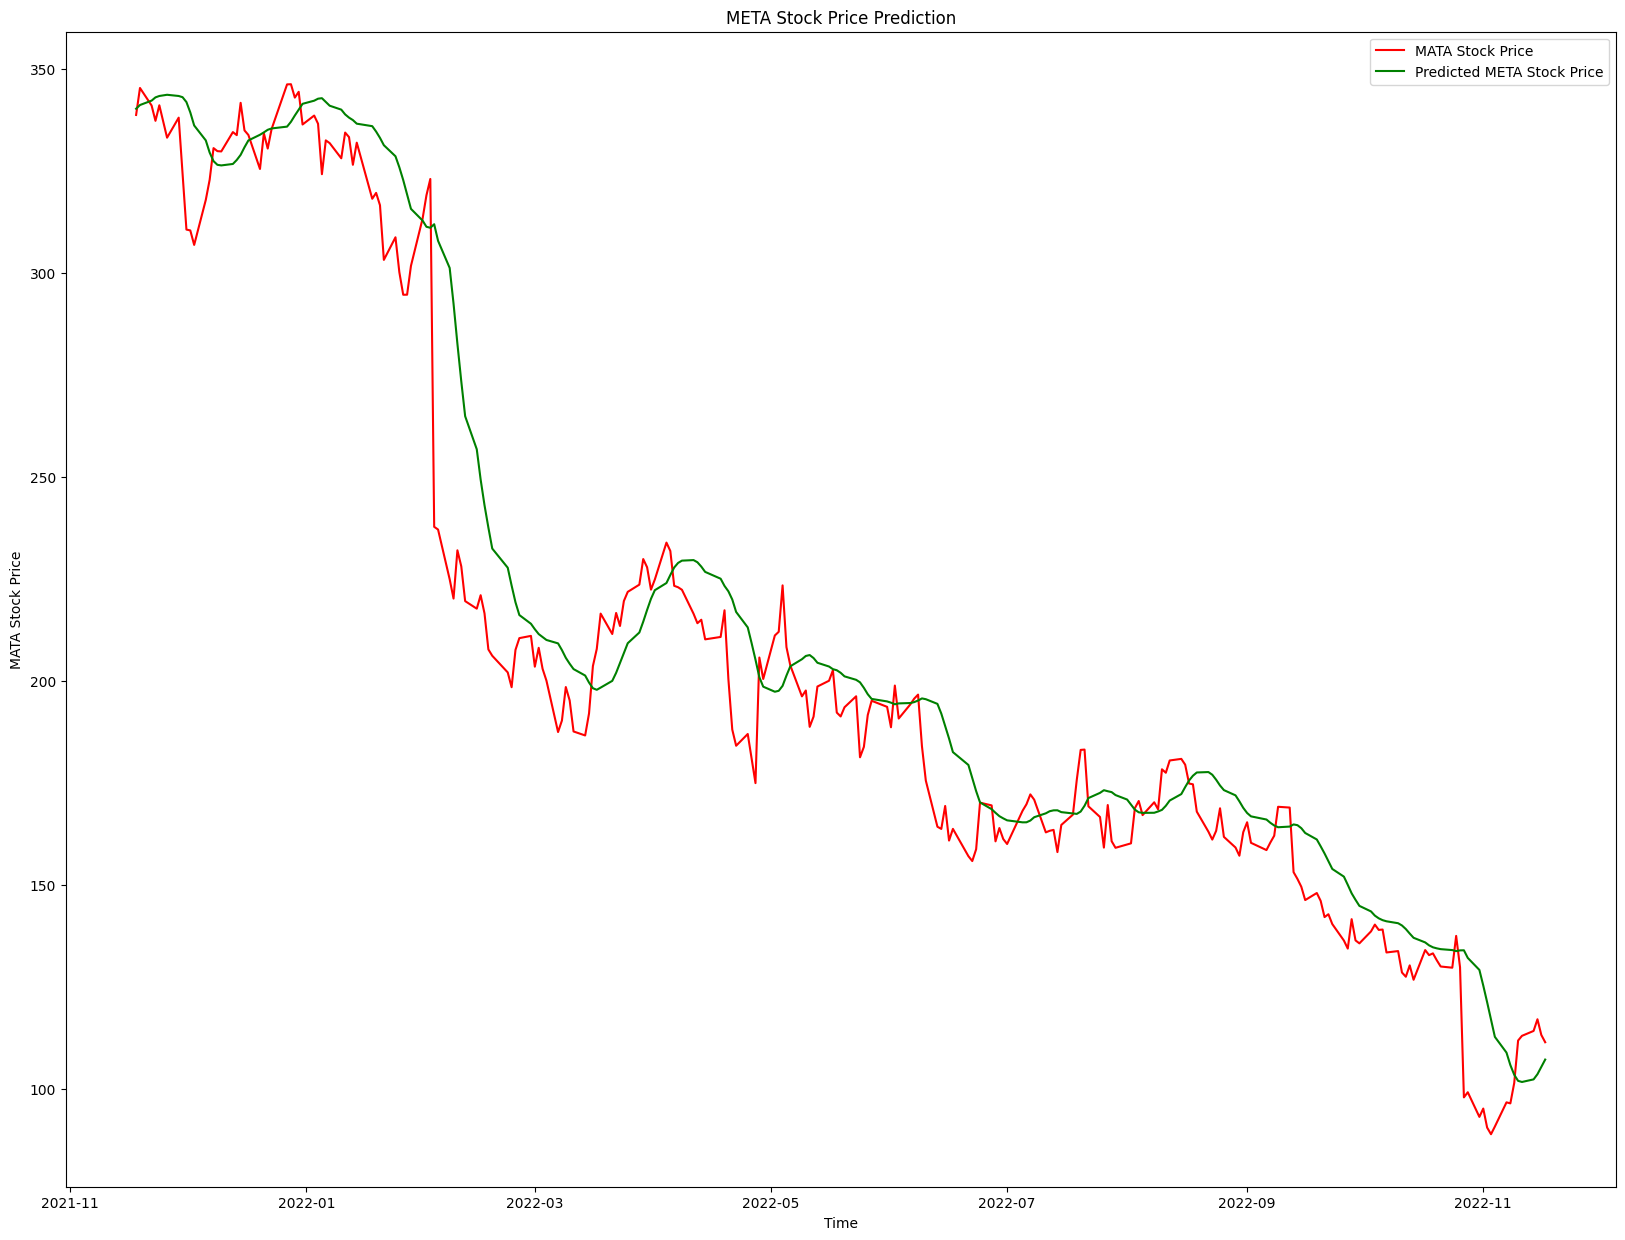

In [12]:
#Sort the dataset on date time and filter “Date” and “Close” columns
data2=df2.sort_index(ascending=True,axis=0)
new_dataset2=pd.DataFrame(index=range(0,len(df2)),columns=['Date','Close'])
for i in range(0,len(data2)):
    new_dataset2["Date"][i]=data2['Date'][i]
    new_dataset2["Close"][i]=data2["Close"][i]

#Normalize the new filtered dataset:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset2.index=new_dataset2.Date
new_dataset2.drop("Date",axis=1,inplace=True)
final_dataset2=new_dataset2.values

train_data2=final_dataset2[0:1007,:]
valid_data2=final_dataset2[1007:,:]

scaled_data2=scaler.fit_transform(final_dataset2)
x_train_data2,y_train_data2=[],[]
for i in range(60,len(train_data2)):
    x_train_data2.append(scaled_data2[i-60:i,0])
    y_train_data2.append(scaled_data2[i,0])

x_train_data2,y_train_data1=np.array(x_train_data2),np.array(y_train_data2)
x_train_data2=np.reshape(x_train_data2,(x_train_data2.shape[0],x_train_data2.shape[1],1))

#Build and train the LSTM model:
lstm_model2=Sequential()
lstm_model2.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data2.shape[1],1)))
lstm_model2.add(LSTM(units=50))
lstm_model2.add(Dense(1))
inputs_data2=new_dataset2[len(new_dataset2)-len(valid_data2)-60:].values
inputs_data2=inputs_data2.reshape(-1,1)
inputs_data2=scaler.transform(inputs_data2)
lstm_model2.compile(loss='mean_squared_error',optimizer='adam')
lstm_model2.fit(np.asarray(x_train_data2),np.asarray(y_train_data2),epochs=1,batch_size=1,verbose=2)

# Take a sample of a dataset to make stock price predictions using the LSTM model
X_test2=[]
for i in range(60,inputs_data2.shape[0]):
    X_test2.append(inputs_data2[i-60:i,0])
X_test2=np.array(X_test2)
X_test2=np.reshape(X_test2,(X_test2.shape[0],X_test2.shape[1],1))
predicted_closing_price2=lstm_model2.predict(X_test2)
predicted_closing_price2=scaler.inverse_transform(predicted_closing_price2)
#Save the LSTM model
lstm_model2.save("saved_model_META.h5")

#Visualize the predicted stock costs with actual stock costs
train_data2=new_dataset2[:1007]
valid_data2=new_dataset2[1007:]
valid_data2['Predictions']=predicted_closing_price2

plt.plot(valid_data2['Close'], color = 'red', label = 'MATA Stock Price')
plt.plot(valid_data2['Predictions'], color = 'green', label = 'Predicted META Stock Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('MATA Stock Price')

# displaying the title
plt.title("META Stock Price Prediction")
plt.show()

## Microsoft Dataset

In [13]:
#Read the dataset for AAPL
df3=pd.read_csv("MSFT.csv")
df3.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,2022-11-17,237.779999,243.250000,237.630005,241.679993,241.679993,23103700,MSFT
1,2022-11-16,242.789993,243.800003,240.419998,241.729996,241.729996,24093300,MSFT
2,2022-11-15,245.660004,247.000000,240.029999,241.970001,241.290009,31390100,MSFT
3,2022-11-14,241.990005,243.910004,239.210007,241.550003,240.871185,31123300,MSFT
4,2022-11-11,242.990005,247.990005,241.929993,247.110001,246.415558,34600900,MSFT


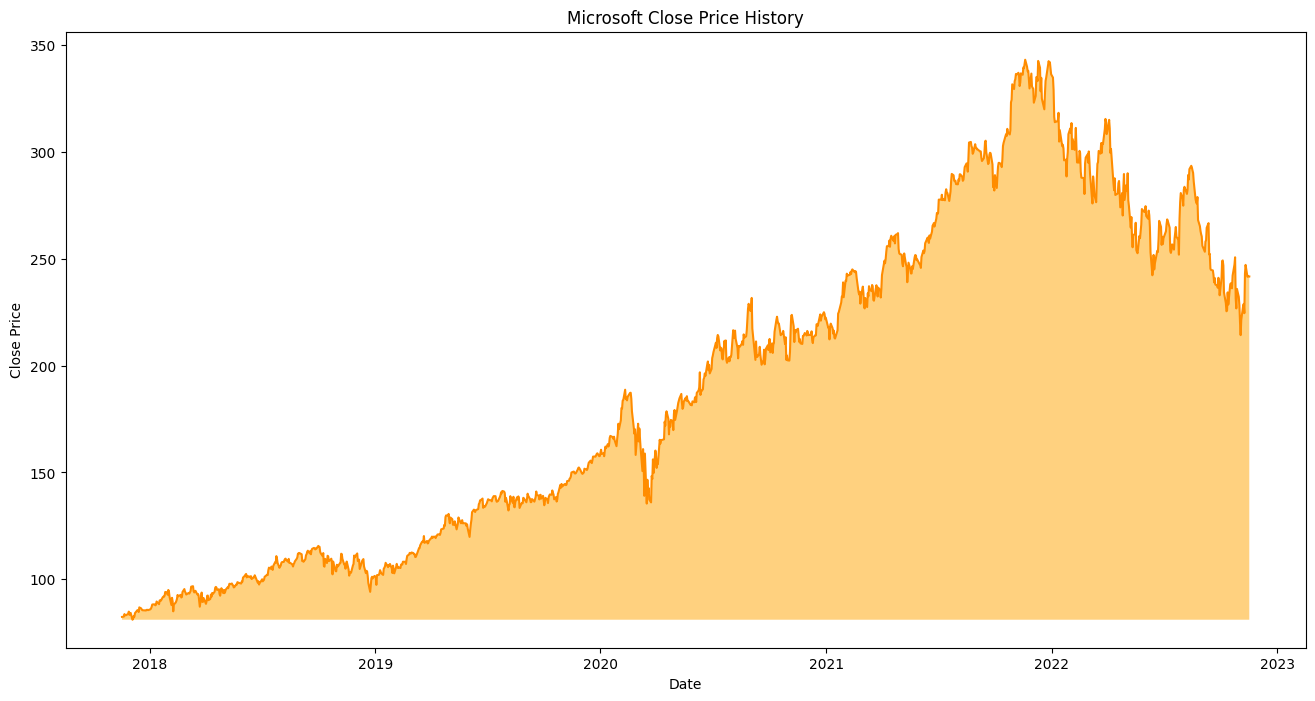

In [14]:
#Analyze the Microsoft closing prices from dataframe
df3["Date"]=pd.to_datetime(df3.Date,format="%Y-%m-%d")
df3.index=df3['Date']
Closemin = df3.Close.min()
plt.figure(figsize=(16,8))
plt.plot(df3["Close"],label='MSFT Close Price History', color='darkorange')
plt.xlabel('Date')
plt.ylabel('Close Price')

# displaying the title
plt.title("Microsoft Close Price History")
plt.fill_between(df3.index, Closemin, df3.Close, facecolor='orange', alpha = 0.5)

### Build and train the LSTM model for Microsoft

In [15]:
#Sort the dataset on date time and filter “Date” and “Close” columns
data3=df3.sort_index(ascending=True,axis=0)
new_dataset3=pd.DataFrame(index=range(0,len(df3)),columns=['Date','Close'])
for i in range(0,len(data3)):
    new_dataset3["Date"][i]=data3['Date'][i]
    new_dataset3["Close"][i]=data3["Close"][i]

#Normalize the new filtered dataset:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset3.index=new_dataset3.Date
new_dataset3.drop("Date",axis=1,inplace=True)
final_dataset3=new_dataset3.values

train_data3=final_dataset3[0:1007,:]
valid_data3=final_dataset3[1007:,:]

scaled_data3=scaler.fit_transform(final_dataset3)
x_train_data3,y_train_data3=[],[]
for i in range(60,len(train_data3)):
    x_train_data3.append(scaled_data3[i-60:i,0])
    y_train_data3.append(scaled_data3[i,0])

x_train_data3,y_train_data3=np.array(x_train_data3),np.array(y_train_data3)
x_train_data3=np.reshape(x_train_data3,(x_train_data3.shape[0],x_train_data3.shape[1],1))

#Build and train the LSTM model:
lstm_model3=Sequential()
lstm_model3.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data3.shape[1],1)))
lstm_model3.add(LSTM(units=50))
lstm_model3.add(Dense(1))
inputs_data3=new_dataset3[len(new_dataset3)-len(valid_data3)-60:].values
inputs_data3=inputs_data3.reshape(-1,1)
inputs_data3=scaler.transform(inputs_data3)
lstm_model3.compile(loss='mean_squared_error',optimizer='adam')
lstm_model3.fit(x_train_data3,y_train_data3,epochs=1,batch_size=1,verbose=2)

2022-12-15 09:56:43.596264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:56:43.730022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:56:43.840803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:56:43.964125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:56:44.152878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


947/947 - 29s - loss: 0.0033 - 29s/epoch - 31ms/step


2022-12-15 09:57:11.756368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:57:11.811819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:57:11.911603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 35ms/step


/var/folders/p9/5_9zfv8x779996pp8x3dr8hr0000gn/T/ipykernel_15474/174300738.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data3['Predictions']=predicted_closing_price3


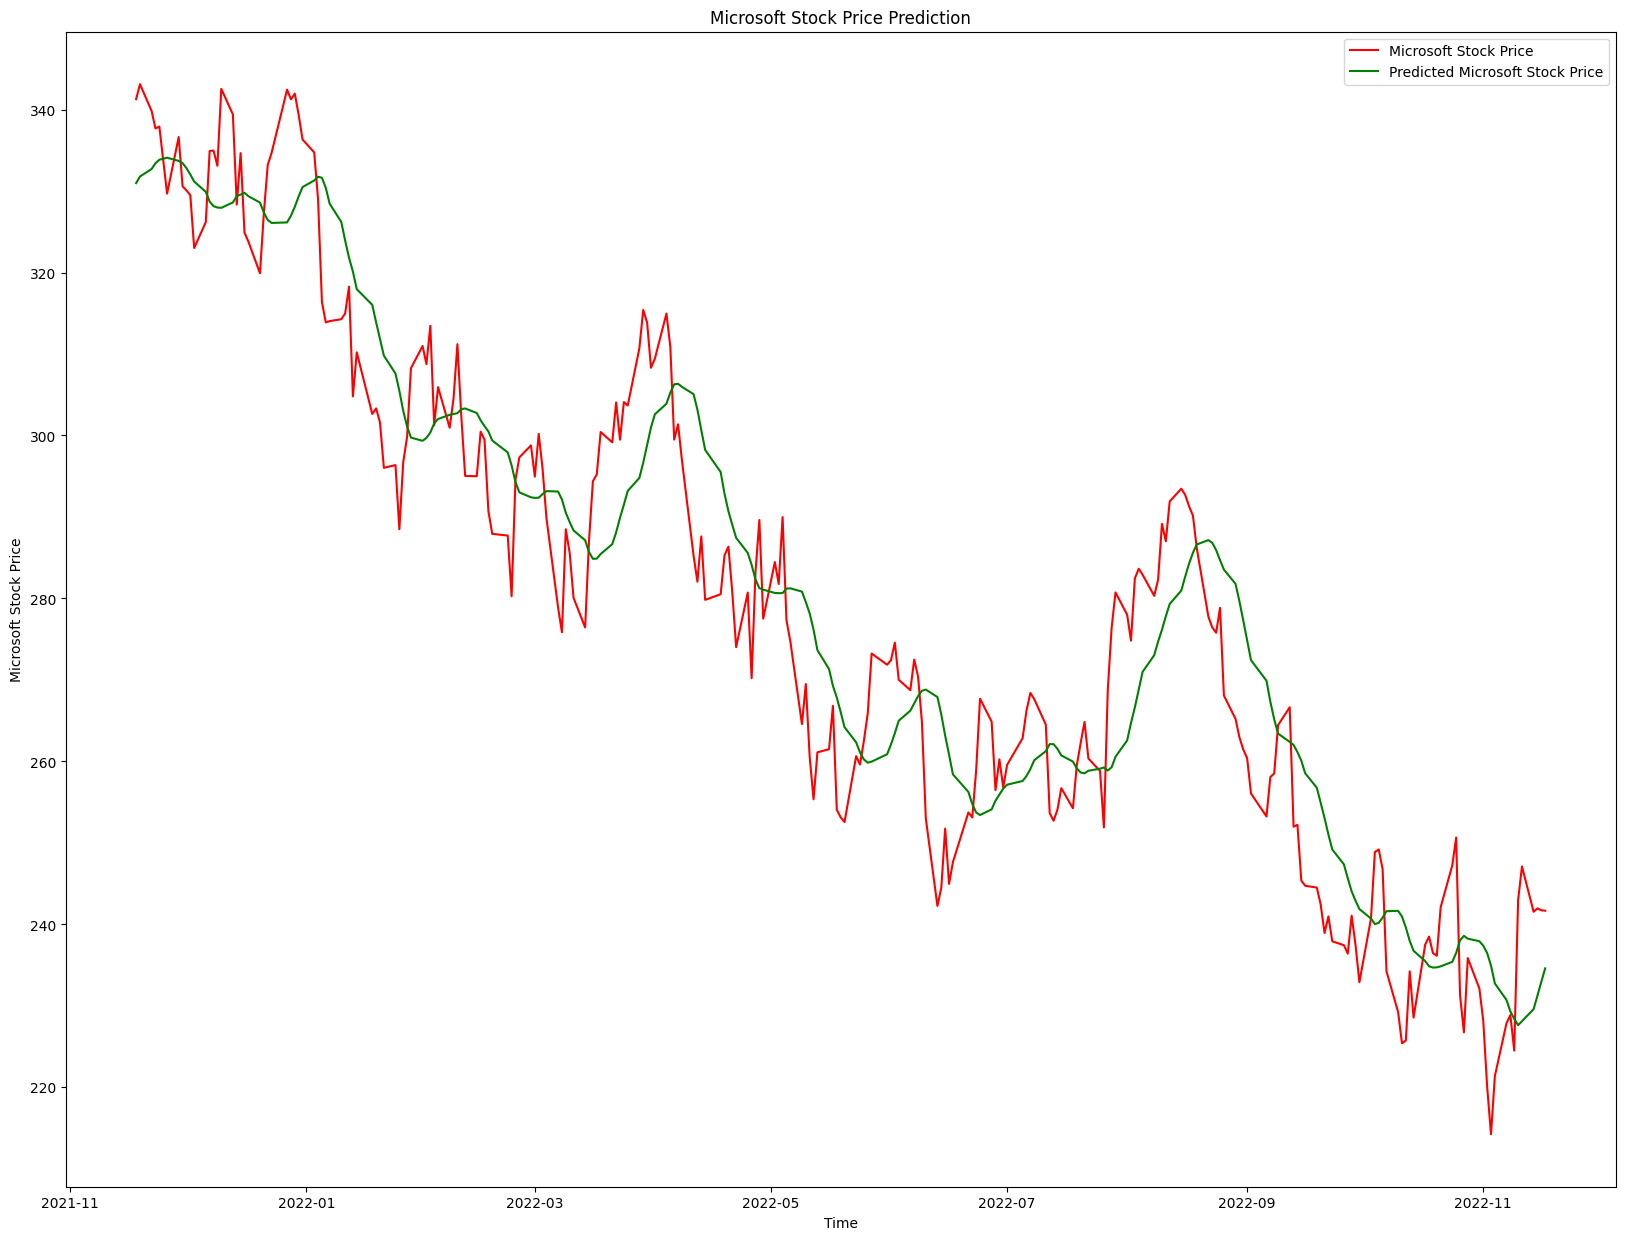

In [16]:
# Take a sample of a dataset to make stock price predictions using the LSTM model
X_test3=[]
for i in range(60,inputs_data3.shape[0]):
    X_test3.append(inputs_data3[i-60:i,0])
X_test3=np.array(X_test3)
X_test3=np.reshape(X_test3,(X_test3.shape[0],X_test3.shape[1],1))
predicted_closing_price3=lstm_model3.predict(X_test3)
predicted_closing_price3=scaler.inverse_transform(predicted_closing_price3)
#Save the LSTM model
lstm_model1.save("saved_model_MSFT.h5")

#Visualize the predicted stock costs with actual stock costs
train_data3=new_dataset3[:1007]
valid_data3 = new_dataset3[1007:]
valid_data3['Predictions']=predicted_closing_price3
#plt.plot(train_data1["Close"])
#plt.plot(valid_data1[['Close',"Predictions"]])
plt.plot(valid_data3['Close'], color = 'red', label = 'Microsoft Stock Price')
plt.plot(valid_data3['Predictions'], color = 'green', label = 'Predicted Microsoft Stock Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Microsoft Stock Price')

# displaying the title
plt.title("Microsoft Stock Price Prediction")
plt.show()


## Tesla Dataset

In [17]:
#Read the dataset for AAPL
df4=pd.read_csv("TSLA.csv")
df4.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,2022-11-17,183.960007,186.160004,180.899994,183.169998,183.169998,64187200,TSLA
1,2022-11-16,191.509995,192.570007,185.660004,186.919998,186.919998,66567600,TSLA
2,2022-11-15,195.880005,200.820007,192.059998,194.419998,194.419998,91293800,TSLA
3,2022-11-14,192.770004,195.729996,186.339996,190.949997,190.949997,92226600,TSLA
4,2022-11-11,186.000000,196.520004,182.589996,195.970001,195.970001,114229200,TSLA


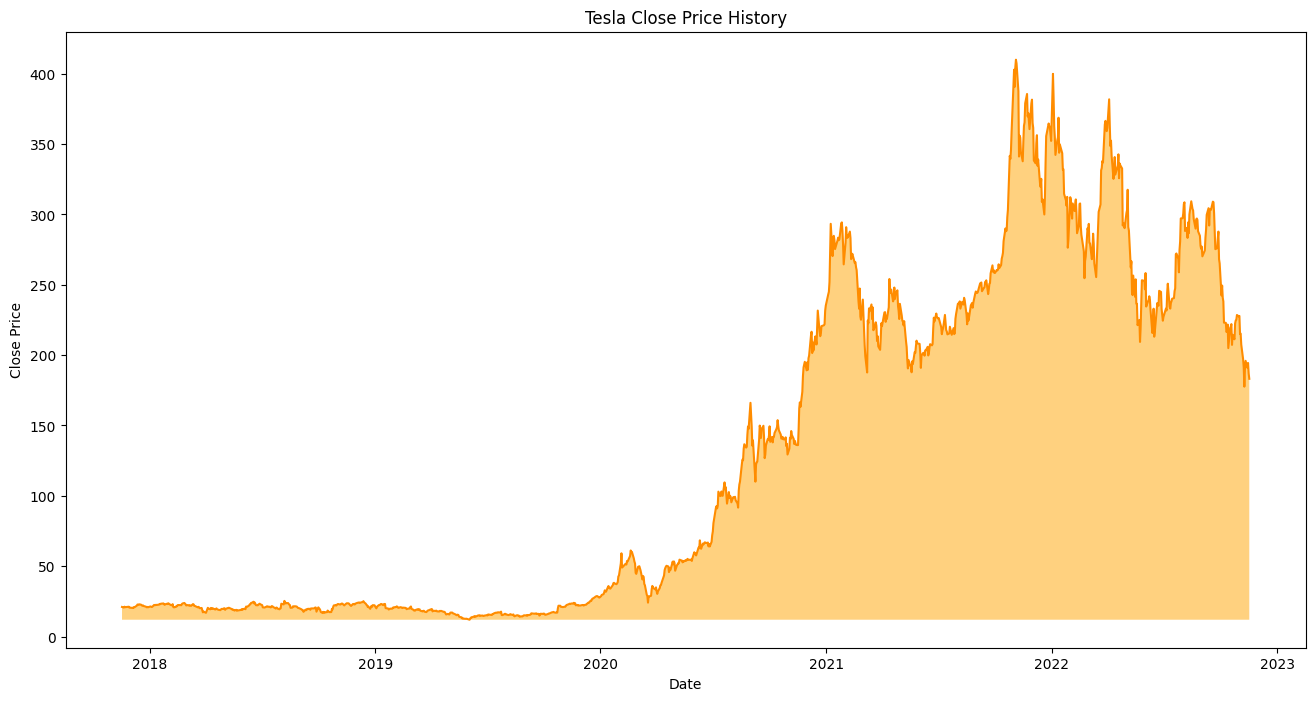

In [18]:
#Analyze the Tesla closing prices from dataframe
df4["Date"]=pd.to_datetime(df4.Date,format="%Y-%m-%d")
df4.index=df4['Date']
Closemin = df4.Close.min()
plt.figure(figsize=(16,8))
plt.plot(df4["Close"],label='Tesla Close Price History', color='darkorange')
plt.xlabel('Date')
plt.ylabel('Close Price')

# displaying the title
plt.title("Tesla Close Price History")
plt.fill_between(df4.index, Closemin, df4.Close, facecolor='orange', alpha = 0.5)

### Build and train the LSTM model for Tesla

In [19]:
#Sort the dataset on date time and filter “Date” and “Close” columns
data4=df4.sort_index(ascending=True,axis=0)
new_dataset4=pd.DataFrame(index=range(0,len(df4)),columns=['Date','Close'])
for i in range(0,len(data4)):
    new_dataset4["Date"][i]=data4['Date'][i]
    new_dataset4["Close"][i]=data4["Close"][i]

#Normalize the new filtered dataset:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset4.index=new_dataset4.Date
new_dataset4.drop("Date",axis=1,inplace=True)
final_dataset4=new_dataset4.values

train_data4=final_dataset4[0:1007,:]
valid_data4=final_dataset4[1007:,:]

scaled_data4=scaler.fit_transform(final_dataset4)
x_train_data4,y_train_data4=[],[]
for i in range(60,len(train_data4)):
    x_train_data4.append(scaled_data4[i-60:i,0])
    y_train_data4.append(scaled_data4[i,0])

x_train_data4,y_train_data4=np.array(x_train_data4),np.array(y_train_data4)
x_train_data4=np.reshape(x_train_data4,(x_train_data4.shape[0],x_train_data4.shape[1],1))

#Build and train the LSTM model:
lstm_model4=Sequential()
lstm_model4.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data4.shape[1],1)))
lstm_model4.add(LSTM(units=50))
lstm_model4.add(Dense(1))
inputs_data4=new_dataset4[len(new_dataset4)-len(valid_data4)-60:].values
inputs_data4=inputs_data4.reshape(-1,1)
inputs_data4=scaler.transform(inputs_data4)
lstm_model4.compile(loss='mean_squared_error',optimizer='adam')
lstm_model4.fit(x_train_data4,y_train_data4,epochs=1,batch_size=1,verbose=2)

2022-12-15 09:57:14.524400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:57:14.663020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:57:14.765753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:57:14.884527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:57:15.068264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


947/947 - 30s - loss: 0.0037 - 30s/epoch - 32ms/step


2022-12-15 09:57:43.431060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:57:43.490153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:57:43.591137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 36ms/step


/var/folders/p9/5_9zfv8x779996pp8x3dr8hr0000gn/T/ipykernel_15474/3397457096.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data4['Predictions']=predicted_closing_price4


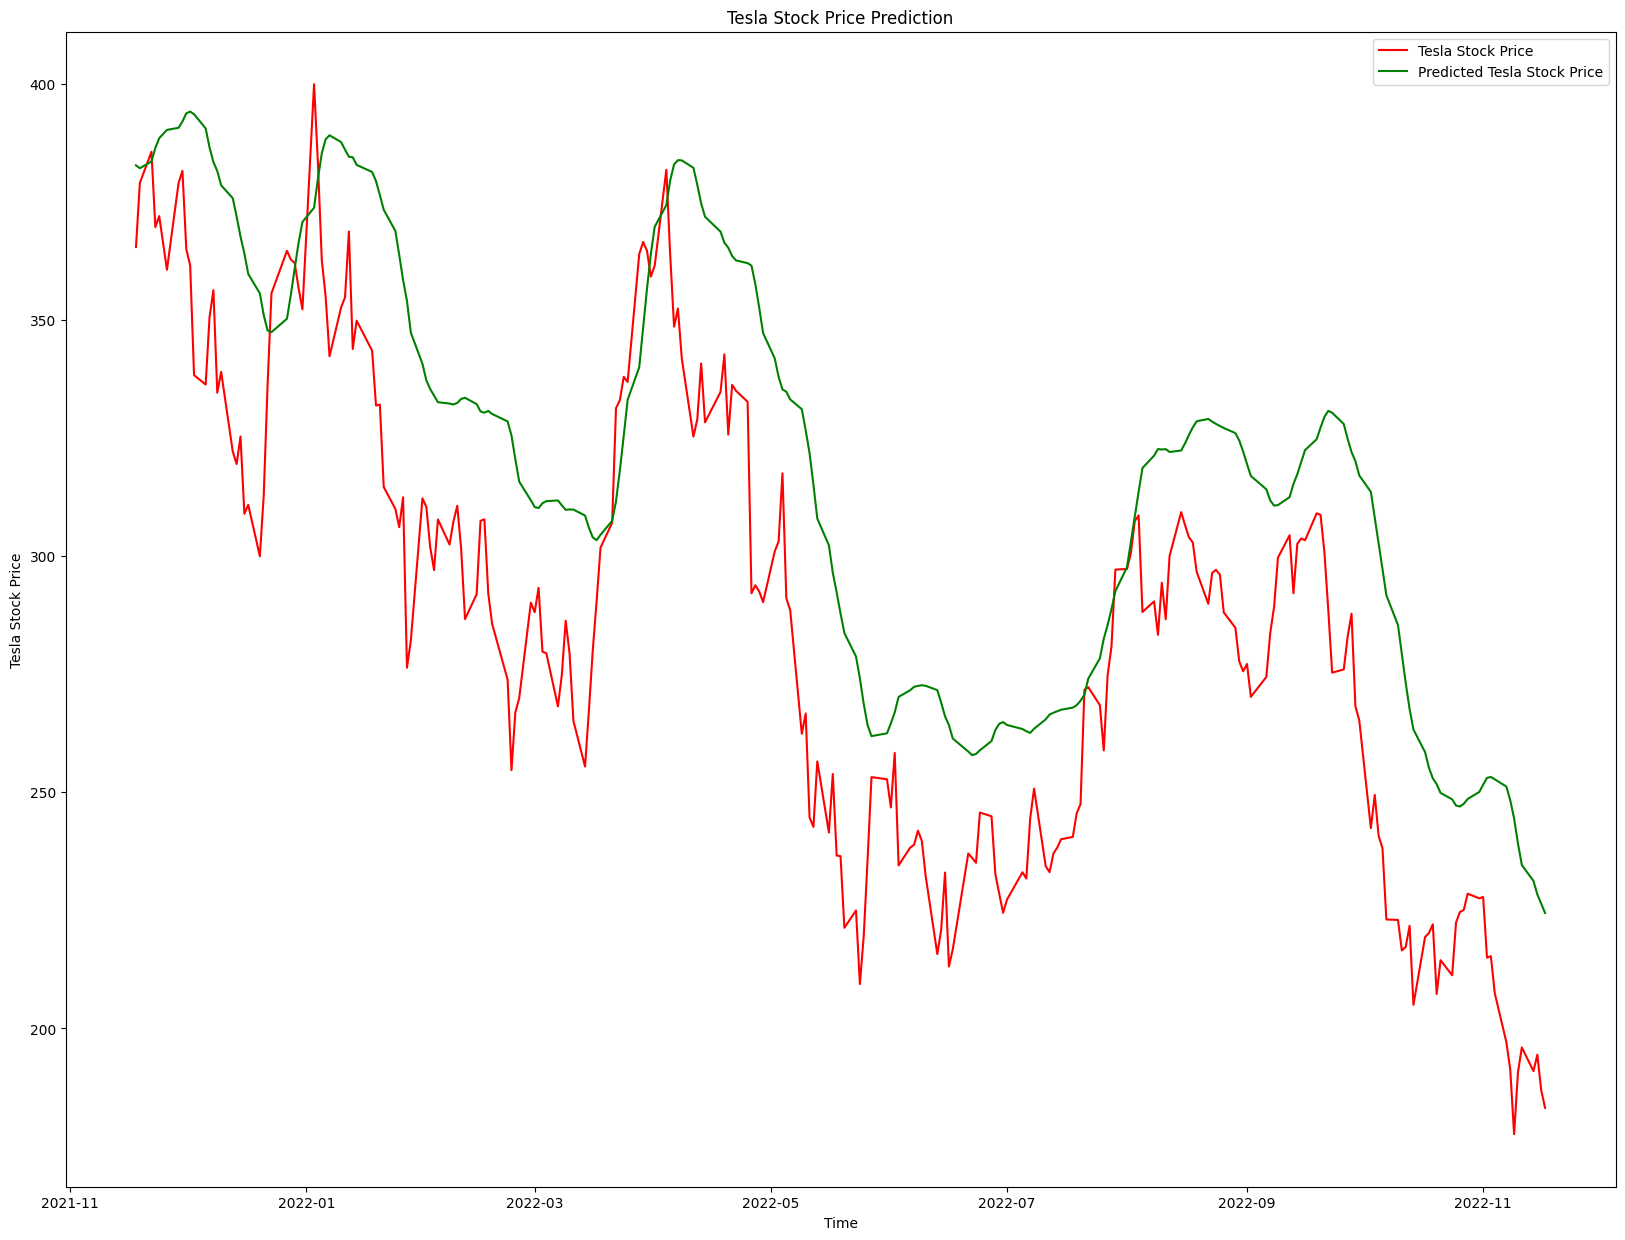

In [20]:
# Take a sample of a dataset to make stock price predictions using the LSTM model
X_test4=[]
for i in range(60,inputs_data4.shape[0]):
    X_test4.append(inputs_data4[i-60:i,0])
X_test4=np.array(X_test4)
X_test4=np.reshape(X_test4,(X_test4.shape[0],X_test4.shape[1],1))
predicted_closing_price4=lstm_model4.predict(X_test4)
predicted_closing_price4=scaler.inverse_transform(predicted_closing_price4)
#Save the LSTM model
lstm_model4.save("saved_model_TSLA.h5")

#Visualize the predicted stock costs with actual stock costs
train_data4=new_dataset4[:1007]
valid_data4 = new_dataset4[1007:]
valid_data4['Predictions']=predicted_closing_price4
#plt.plot(train_data1["Close"])
#plt.plot(valid_data1[['Close',"Predictions"]])
plt.plot(valid_data4['Close'], color = 'red', label = 'Tesla Stock Price')
plt.plot(valid_data4['Predictions'], color = 'green', label = 'Predicted Tesla Stock Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')

# displaying the title
plt.title("Tesla Stock Price Prediction")
plt.show()


In [21]:
!python3 stock_app.py

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

2022-12-15 09:57:47.799004: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-15 09:57:47.799146: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-15 09:57:49.661365: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-15 09:57:49.956507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:57:50.015051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for dev

### Data Validation for NFLX Dataset

In [ ]:
#Sort the dataset on date time and filter “Date” and “Close” columns
from keras.models import Sequential
from keras.layers import Dense

data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

#Normalize the new filtered dataset:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset.index=new_dataset.Date

new_dataset.drop("Date",axis=1,inplace=True)


final_dataset=new_dataset.values

train_data=final_dataset[0:1007,:]
valid_data=final_dataset[1007:,:]

scaled_data=scaler.fit_transform(final_dataset)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):

    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_test_data, y_test_data = [],[]
for i in range(60,len(valid_data)):
    x_test_data.append(scaled_data[i-60:i,0])
    y_test_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

x_test_data,y_test_data=np.array(x_test_data),np.array(y_test_data)
x_test_data = np.reshape(x_test_data,(x_test_data.shape[0], x_test_data.shape[1], 1))

print(x_train_data.shape, y_train_data.shape)
print(x_test_data.shape, y_test_data.shape)

(947, 60, 1) (947,)
(191, 60, 1) (191,)


Epoch 1/50


2022-12-15 10:04:44.942632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 10:04:45.122428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 10:04:45.253493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 10:04:45.406467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 10:04:45.632677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 10:04:47.193293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 10:04:47.254983: I tensorflow/core/grappler/optimizers/cust

10/10 - 4s - loss: 0.0791 - val_loss: 0.0319 - 4s/epoch - 407ms/step
Epoch 2/50
10/10 - 0s - loss: 0.0369 - val_loss: 0.0016 - 458ms/epoch - 46ms/step
Epoch 3/50
10/10 - 0s - loss: 0.0131 - val_loss: 0.0015 - 359ms/epoch - 36ms/step
Epoch 4/50
10/10 - 0s - loss: 0.0056 - val_loss: 0.0060 - 352ms/epoch - 35ms/step
Epoch 5/50
10/10 - 0s - loss: 0.0060 - val_loss: 0.0015 - 353ms/epoch - 35ms/step
Epoch 6/50
10/10 - 0s - loss: 0.0028 - val_loss: 0.0028 - 365ms/epoch - 37ms/step
Epoch 7/50
10/10 - 0s - loss: 0.0031 - val_loss: 0.0016 - 362ms/epoch - 36ms/step
Epoch 8/50
10/10 - 0s - loss: 0.0025 - val_loss: 0.0016 - 354ms/epoch - 35ms/step
Epoch 9/50
10/10 - 0s - loss: 0.0024 - val_loss: 0.0015 - 355ms/epoch - 35ms/step
Epoch 10/50
10/10 - 0s - loss: 0.0023 - val_loss: 0.0015 - 354ms/epoch - 35ms/step
Epoch 11/50
10/10 - 0s - loss: 0.0022 - val_loss: 0.0015 - 347ms/epoch - 35ms/step
Epoch 12/50
10/10 - 0s - loss: 0.0022 - val_loss: 0.0015 - 346ms/epoch - 35ms/step
Epoch 13/50
10/10 - 0s - l

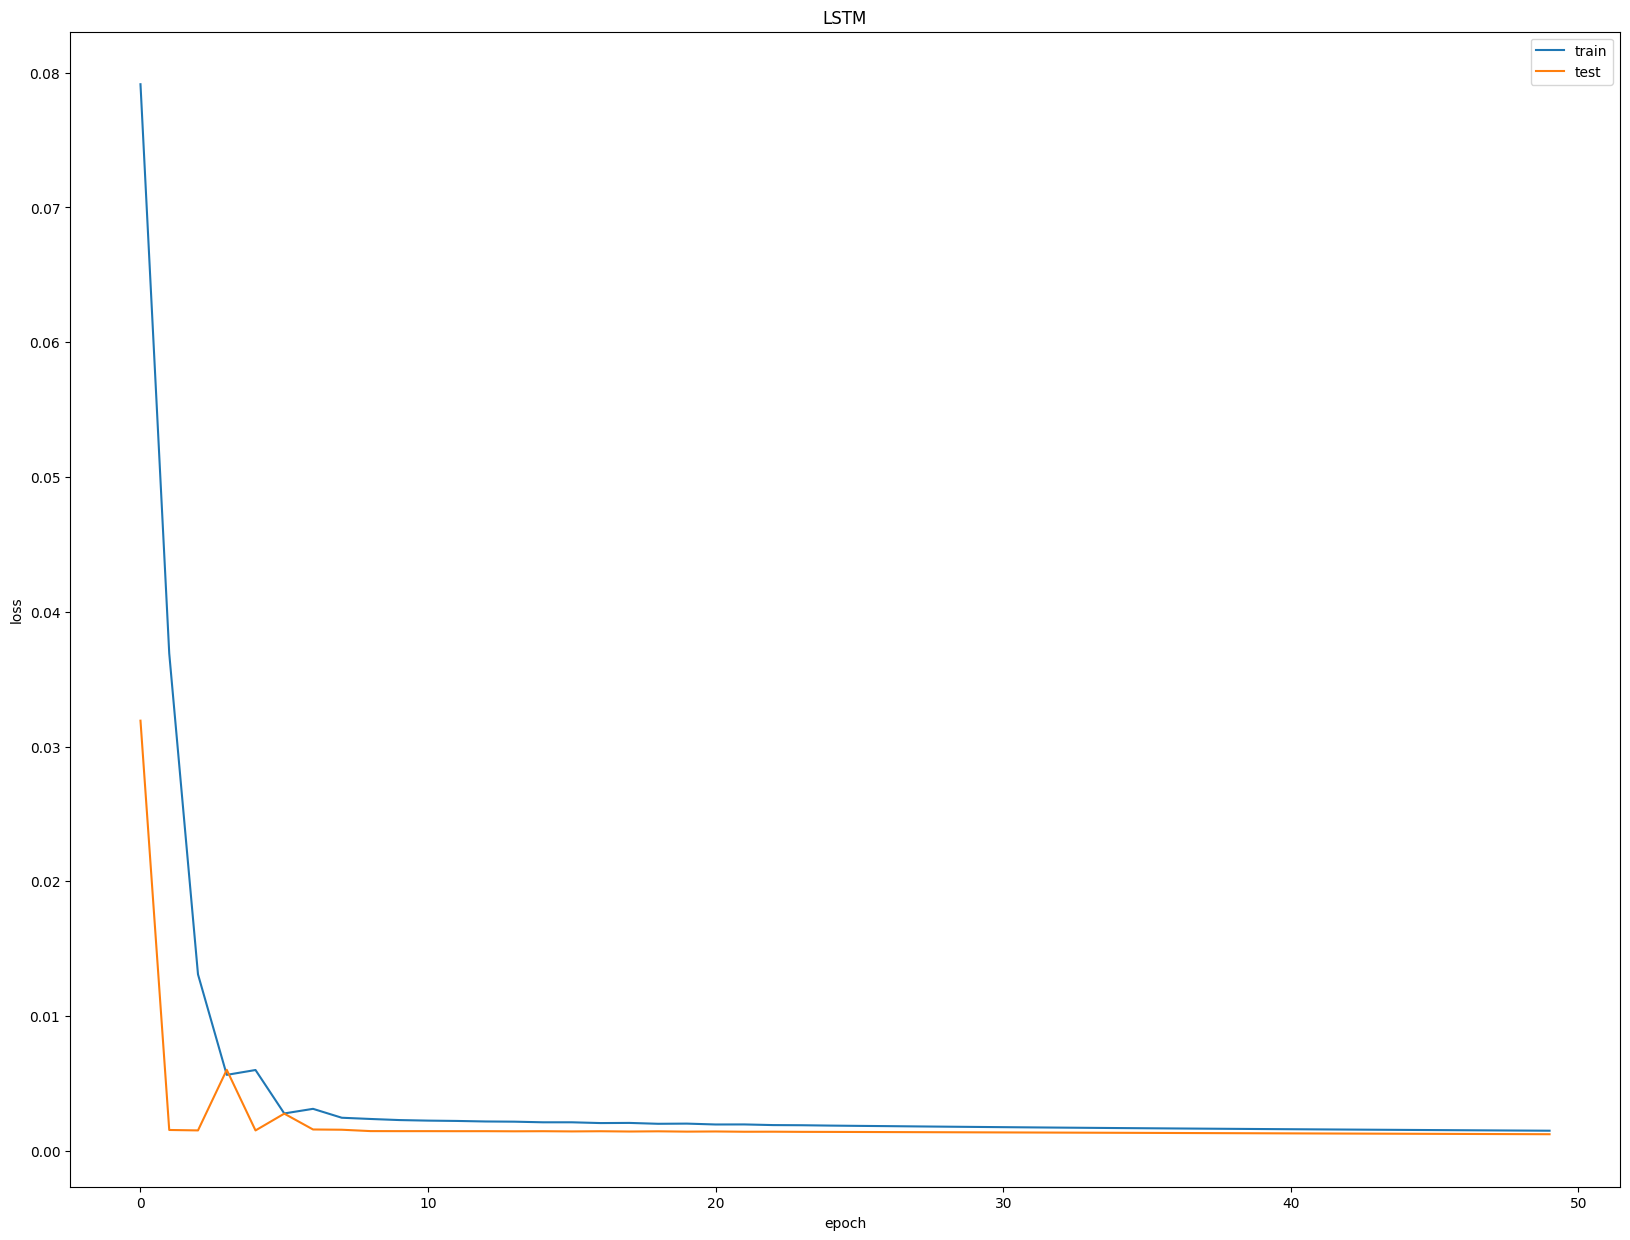

In [23]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=( x_train_data.shape[1], 1)))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
history = lstm_model.fit(x_train_data,y_train_data,epochs=50,batch_size=100, verbose=2,shuffle=False, validation_data=(x_test_data, y_test_data))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('LSTM', fontsize='12')
plt.ylabel('loss', fontsize='10')
plt.xlabel('epoch', fontsize='10')
plt.legend()
plt.show()

In [24]:
predicted_closing_price=lstm_model.predict(x_test_data)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)
mae=mean_absolute_percentage_error(y_test_data, predicted_closing_price)
print("mae: ", mae)
mse=mean_squared_error(y_test_data, predicted_closing_price)
print("mse: ", mse)
rmse = sqrt(mse)
print("rmse: ", rmse)

2022-12-15 10:05:06.344638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 10:05:06.402138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 10:05:06.494335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 45ms/step
mae:  1053.2796156468312
mse:  116206.66663934429
rmse:  340.89098937834115


Epoch 1/50


2022-12-15 10:05:08.265208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 10:05:08.450515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 10:05:08.561152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 10:05:08.756195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/11 [=>............................] - ETA: 22s - loss: 0.6301 - accuracy: 0.0000e+00

2022-12-15 10:05:08.955566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.6300 - accuracy: 0.0000e+00

2022-12-15 10:05:10.307971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 10:05:10.377524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 10:05:10.471832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 4s 171ms/step - loss: 0.6300 - accuracy: 0.0000e+00 - val_loss: 0.5888 - val_accuracy: 0.0035
Epoch 2/50
11/11 [==============================] - 0s 44ms/step - loss: 0.6276 - accuracy: 0.0000e+00 - val_loss: 0.5783 - val_accuracy: 0.0035
Epoch 3/50
11/11 [==============================] - 0s 45ms/step - loss: 0.6272 - accuracy: 0.0000e+00 - val_loss: 0.5771 - val_accuracy: 0.0035
Epoch 4/50
11/11 [==============================] - 0s 44ms/step - loss: 0.6269 - accuracy: 0.0000e+00 - val_loss: 0.5772 - val_accuracy: 0.0035
Epoch 5/50
11/11 [==============================] - 0s 44ms/step - loss: 0.6267 - accuracy: 0.0000e+00 - val_loss: 0.5771 - val_accuracy: 0.0035
Epoch 6/50
11/11 [==============================] - 0s 44ms/step - loss: 0.6265 - accuracy: 0.0000e+00 - val_loss: 0.5771 - val_accuracy: 0.0035
Epoch 7/50
11/11 [==============================] - 0s 44ms/step - loss: 0.6266 - accuracy: 0.0000e+00 - val_loss: 0.5769 - val_accuracy: 0.

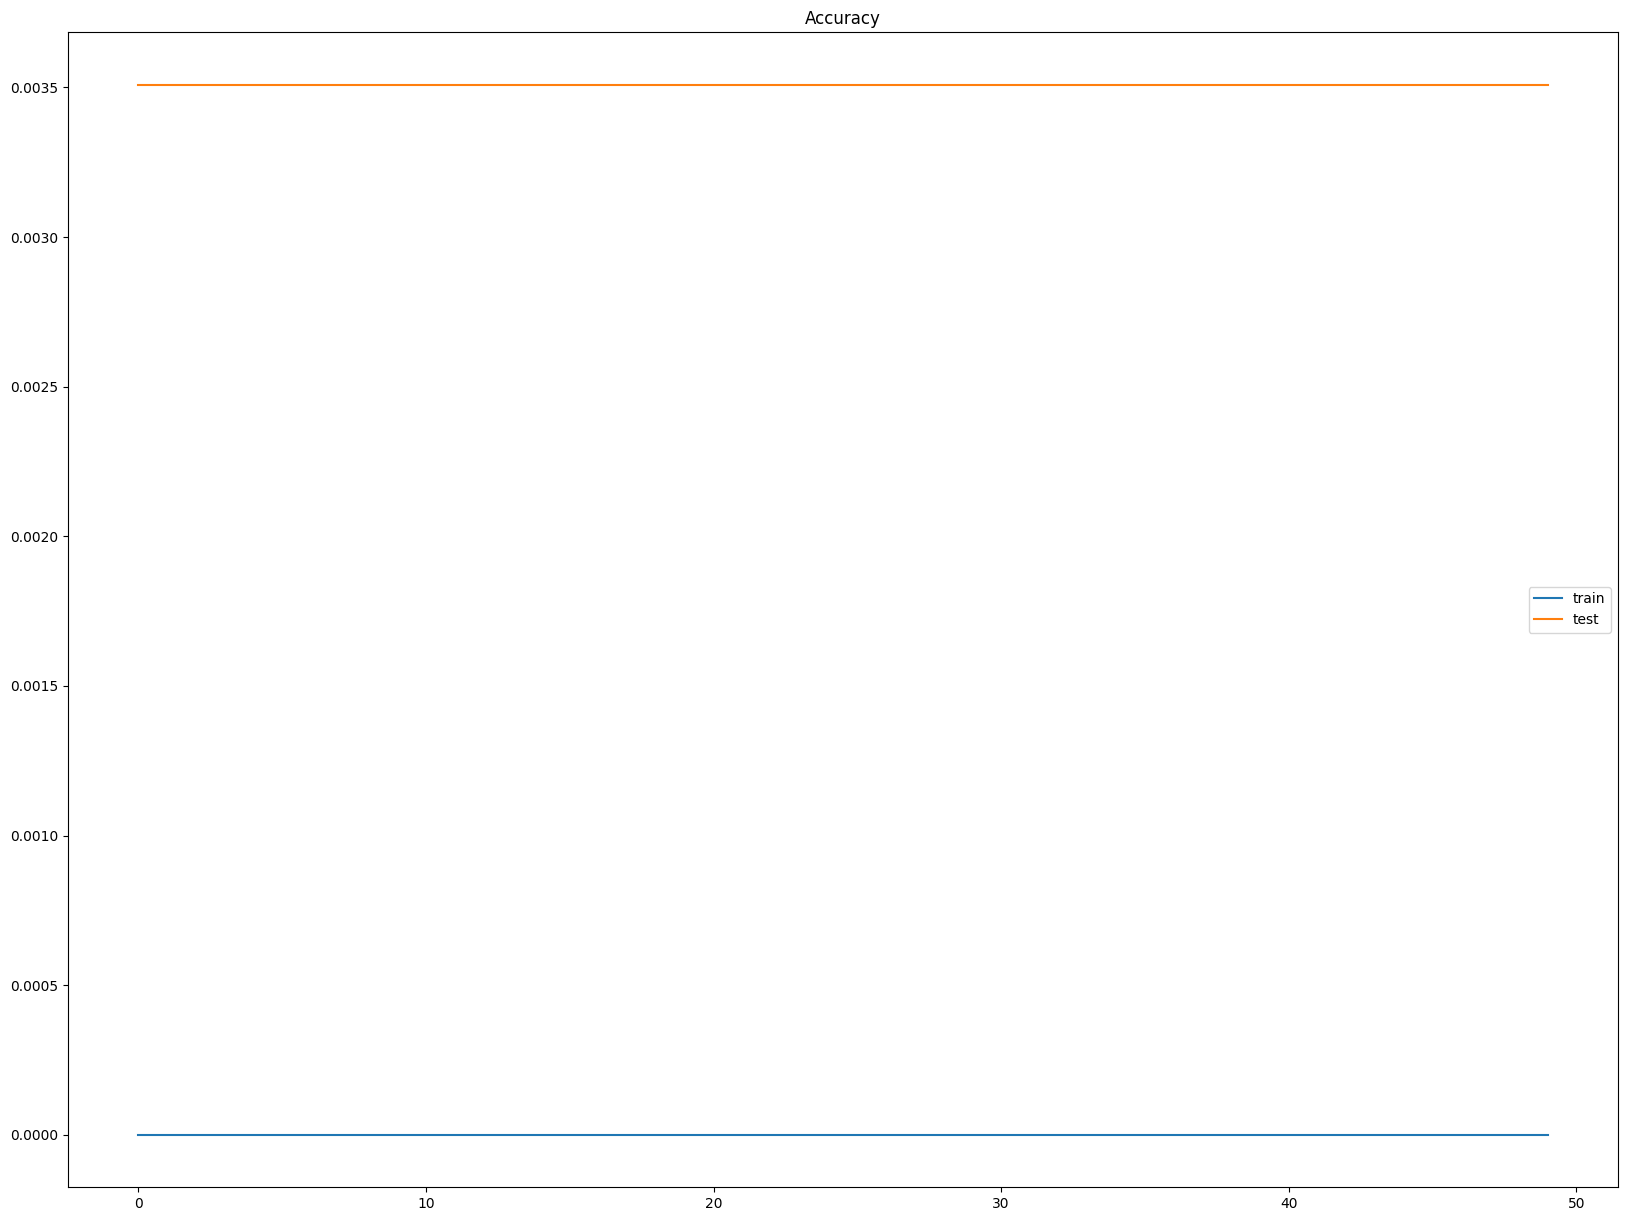

In [25]:
lstm_model.compile(loss='binary_crossentropy', optimizer='adam',
                             metrics=["accuracy"])
history = lstm_model.fit(x_train_data,y_train_data,epochs=50,batch_size=64, validation_split=0.3)
print("history.history:{}".format(history.history))
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()


### Unit Test

In [26]:
import datetime
def test_inputDate(date_text):
    try:
        datetime.datetime.strptime(date_text, '%Y-%m-%d %H:%M:%S')
        print("correct format")
    except ValueError:
        print(date_text)
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")

### Test Case for Date Format

In [27]:
test_inputDate("2022-01-20 00:00:00")

correct format


In [28]:
test_inputDate("2022-01-39 00:00:00")

2022-01-39 00:00:00


ValueError: Incorrect data format, should be YYYY-MM-DD

In [29]:
test_inputDate("2022-01-20 100:00:00")

2022-01-20 100:00:00


ValueError: Incorrect data format, should be YYYY-MM-DD

In [ ]:
# #Sort the dataset on date time and filter “Date” and “Close” columns
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.optimizers import SGD
# data=df.sort_index(ascending=True,axis=0)
# new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
# for i in range(0,len(data)):
#     new_dataset["Date"][i]=data['Date'][i]
#     new_dataset["Close"][i]=data["Close"][i]
# #Normalize the new filtered dataset:
# scaler=MinMaxScaler(feature_range=(0,1))
# new_dataset.index=new_dataset.Date
# new_dataset.drop("Date",axis=1,inplace=True)
# final_dataset=new_dataset.values
#
# train_data=final_dataset[0:1007,:]
# valid_data=final_dataset[1007:,:]
#
# scaled_data=scaler.fit_transform(final_dataset)
# x_train_data,y_train_data=[],[]
# for i in range(60,len(train_data)):
#     x_train_data.append(scaled_data[i-60:i,0])
#     y_train_data.append(scaled_data[i,0])
#
# x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
# x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))
#
# #Build and train the LSTM model:
# lstm_model=Sequential()
# lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
# lstm_model.add(LSTM(units=50))
# lstm_model.add(Dense(1))
# inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
# inputs_data=inputs_data.reshape(-1,1)
# inputs_data=scaler.transform(inputs_data)
# epochs = 50
# learning_rate = 0.1
# decay_rate = learning_rate / epochs
# momentum = 0.8
# sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# lstm_model.compile(loss='mean_squared_error',optimizer=sgd, metrics=['accuracy'])
# #lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)
# # history = lstm_model.fit(x_train_data,y_train_data,
# #                       epochs=1,
# #                       batch_size=64,
# #                       verbose=1,
# #                       validation_data=(x_train_data,y_train_data))
# # print("history.history:{}".format(history.history))

In [ ]:
# # Take a sample of a dataset to make stock price predictions using the LSTM model
# X_test, Y_test=[],[]
# for i in range(60,inputs_data.shape[0]):
#     X_test.append(inputs_data[i-60:i,0])
#     Y_test.append(inputs_data[i,0])
# X_test=np.array(X_test)
# #X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
# Y_test=np.array(Y_test)
# #Y_test=np.reshape(Y_test,(Y_test.shape[0],Y_test.shape[1],1))
#
# predicted_closing_price=lstm_model.predict(X_test)
# predicted_closing_price=scaler.inverse_transform(predicted_closing_price)
#
# history = lstm_model.fit(x_train_data,y_train_data,
#                        epochs=20,
#                        batch_size=64,
#                        verbose=1,
#                        validation_data=(X_test, Y_test))
# print("history.history:{}".format(history.history))